In [1]:

import warnings 
warnings.filterwarnings('ignore')

import tensorflow as tf 
from tensorflow import keras 

import cv2 

import numpy as np 
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt 


2024-07-07 13:18:03.338694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 13:18:03.338749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 13:18:03.340257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
'''
PROJECT - TRAJECTORY PREDICTION OF AUTOMOBILES / PREDESTRIANS FOR SELF DRVING CARS 

PIPELINE - 
1. Took dataset of windshield view with Bounding Boxes , did preprocessing and used Transfer LEarning to 
re-train the model a bit to learn the features in new dataset and predicted Centre( exact location) of the predestrain
/vehicle 

2. Then , tokk the last feature map fromCNN ( contain imp features ) and passed it to the RNN ( after reshaping input)
such that ( timesteps = Spatial Dim , features= no of new channels formed  in Final feature map )

3. trained my LSTM network for One-strp forecasting( New pos of Pedestrian )

Do this work now 

4. Now , wok on  tuning both the models m fianl results , do mUlti-Step Forecasting to predict future 10 steps 

5. And draw lines represing them and integrate it toa  video frame . 

6. How I did Multi Step Forecasting
- To took an image , did One-Step Forecasting and found 1 Future(x,y) coordinate. 
Then , made a rectangle in the original Image ( using previously predicted x,y) Now , passed this new 
Edited Image in the Same LSTM network and then found another Prediction 


We can Improve the results By drawing Bounding boxs ( just i like Dew above in the training Images dataset )
'''

'\nPROJECT - TRAJECTORY PREDICTION OF AUTOMOBILES / PREDESTRIANS FOR SELF DRVING CARS \n\nPIPELINE - \n1. Took dataset of windshield view with Bounding Boxes , did preprocessing and used Transfer LEarning to \nre-train the model a bit to learn the features in new dataset and predicted Centre( exact location) of the predestrain\n/vehicle \n\n2. Then , tokk the last feature map fromCNN ( contain imp features ) and passed it to the RNN ( after reshaping input)\nsuch that ( timesteps = Spatial Dim , features= no of new channels formed  in Final feature map )\n\n3. trained my LSTM network for One-strp forecasting( New pos of Pedestrian )\n\nDo this work now \n\n4. Now , wok on  tuning both the models m fianl results , do mUlti-Step Forecasting to predict future 10 steps \n\n5. And draw lines represing them and integrate it toa  video frame . \n\n6. How I did Multi Step Forecasting\n- To took an image , did One-Step Forecasting and found 1 Future(x,y) coordinate. \nThen , made a rectangle in

In [3]:
data = pd.read_csv("/kaggle/input/self-driving-cars/labels_train.csv")

data['area'] = abs( data['xmin']-data['xmax'])* abs( data['ymin']-data['ymax'])

In [4]:
data = data[ (data['area']>=2000) & (data['xmin']>=50) & (data['xmin']<=200) & (data['xmax']<=350) & (data['xmax']>=200) ]
data.head()

,frame,xmin,xmax,ymin,ymax,class_id,area
327,1478019978686299906.jpg,139,274,124,170,1,6210
337,1478019983689760521.jpg,193,335,122,188,2,9372
1074,1478020241197041221.jpg,109,225,105,168,1,7308
1082,1478020241689891151.jpg,152,246,107,170,1,5922
1092,1478020242196911641.jpg,188,265,107,169,1,4774


In [5]:
data.iloc[0]['frame']


'1478019978686299906.jpg'

In [6]:
''' Define the center of B  Box to find exact location '''
pos = data.copy()

pos['x_pos'] = (pos['xmin'] + pos['xmax'])//2 
pos['y_pos'] = (pos['ymin'] + pos['ymax'])//2 

pos.drop(['xmin' , 'xmax' , 'ymin' , 'ymax' , 'class_id', 'area'] , axis =1  , inplace = True )

In [7]:
pos.head()

,frame,x_pos,y_pos
327,1478019978686299906.jpg,206,147
337,1478019983689760521.jpg,264,155
1074,1478020241197041221.jpg,167,136
1082,1478020241689891151.jpg,199,138
1092,1478020242196911641.jpg,226,138


In [8]:
# img = cv2.imread( "/kaggle/input/self-driving-cars/images/" + pos.iloc[0]['frame'])
# # img = cv2.cvtColor( img , cv2.COLOR_BGR2RGB)
# plt.imshow( img  , cmap = 'gray')
# cv2.rectangle( img , ( pos.iloc[0]['xmin'] ,pos.iloc[0]['ymin']) , ( pos.iloc[0]['xmax'] ,pos.iloc[0]['ymax']) , (0,255,0) , 2)
# plt.imshow( img  , cmap = 'gray')

In [9]:
pos_1 = pos.iloc[: , 1: ]

from sklearn.preprocessing import StandardScaler 
scale = StandardScaler( )
pos[ ['x_pos' , 'y_pos']]  = scale.fit_transform( pos[['x_pos' , 'y_pos' ]] )

# pos.drop( ['x_pos' , 'y_pos'] , axis =1 , inplace =True  )

# pos = pd.concat( [ pos , pos_1 ] , axis =1 )




In [10]:
pos.head()

,frame,x_pos,y_pos
327,1478019978686299906.jpg,-0.028400,-1.293080
337,1478019983689760521.jpg,1.811987,-0.863297
1074,1478020241197041221.jpg,-1.265901,-1.884031
1082,1478020241689891151.jpg,-0.250515,-1.776586
1092,1478020242196911641.jpg,0.606217,-1.776586


In [11]:
''' Take the features of the image , and pass it to LSTM network and use the 
sequential Box Coord as the label '''

from keras.applications  import Xception

base_model =  Xception( include_top = False ,weights= 'imagenet', input_shape = (299 , 299 , 3 )) 


# for layer in base_model.layers :
#     layer.trainable = False 
    
Cnn = keras.models.Sequential([
   base_model,
    keras.layers.GlobalAveragePooling2D() ,
    #keras.layers.Flatten() ,
    keras.layers.Dense( 100 ,activation = 'relu') , 
    keras.layers.Dropout(0.1), 
    keras.layers.Dense(50 , activation = 'relu'), 
    keras.layers.Dropout(0.1 ) ,
    keras.layers.Dense(2)
])

for layer in base_model.layers :
    layer.trainable = False 
    
my_adam = keras.optimizers.Adam(learning_rate=0.01)

Cnn.compile( loss = 'mse' , optimizer = my_adam , metrics=['mae'])

In [12]:
Cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [13]:
'''  Travel in the Dir of images and store first 10 images for training
and their labels PArallely '''

root = "/kaggle/input/self-driving-cars/images/"

Img_data = []
Original_img = []
Labels = []

# no of images you want the tranfer learning to work  on 

for i in range( len(pos)  ):
    img = cv2.imread(root +pos['frame'].iloc[i])
    x_ = pos['x_pos'].iloc[i]
    y_ = pos['y_pos'].iloc[i]
    Original_img.append(img)
    '''Draw a small BB during training to better capture features '''
    cv2.rectangle( img , (int(x_) ,int(y_)) , ( int(x_+ 5) ,int(y_ + 5 ) ) , (0 ,255, 0)  , 3 )
    
    
    img= img/255
    img = cv2.resize( img , (299,299 ))
    Img_data.append(img)
    
    Labels.append([x_ , y_] )
    

In [14]:
Img_data = np.array(Img_data)
Labels = np.array( Labels )
Original_img = np.array( Original_img )

In [15]:
Cnn.fit( Img_data , Labels , batch_size = 16 , epochs = 10  ) 

Epoch 1/10
  1/236 ━━━━━━━━━━━━━━━━━━━━ 1:36:03 25s/step - loss: 1.4855 - mae: 0.8691

I0000 00:00:1720358364.293309     739 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720358364.338056     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


236/236 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 1.0843 - mae: 0.7454
Epoch 2/10


W0000 00:00:1720358405.704710     740 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - loss: 0.4470 - mae: 0.4971
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - loss: 0.4102 - mae: 0.4675
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - loss: 0.3443 - mae: 0.4245
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.3484 - mae: 0.4238
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 0.3331 - mae: 0.4289
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - loss: 0.3544 - mae: 0.4320
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.3339 - mae: 0.4185
Epoch 9/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - loss: 0.3278 - mae: 0.4145
Epoch 10/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - loss: 0.3373 - mae: 0.4203


In [16]:
for layer in base_model.layers :
    layer.trainable = True 

 # retarin after un freezing the CNN weights 
    
Cnn.compile( loss = 'mse' , optimizer = 'adam' , metrics=['mae'])
Cnn.fit( Img_data[: 20] , Labels[: 20] , batch_size = 16 , epochs =  2   )

Epoch 1/2


W0000 00:00:1720358762.294721     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 113s 36s/step - loss: 0.8758 - mae: 0.6583
Epoch 2/2


W0000 00:00:1720358798.396294     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.7467 - mae: 0.6247


In [17]:
base_model_ = Cnn.layers[0]

In [18]:
feature_map = base_model.predict(Img_data[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [19]:
batch , h , w , ch = feature_map.shape


In [20]:
''' to reshape Out of any model to any other mode , ise layers.Reshape( ( h*w , channesl)) '''

Lstm_net = keras.models.Sequential([
    base_model_ , 
    keras.layers.Reshape( ( h*w , ch )) , 
#     keras.layers.Input( shape = ( h*w*ch , )) ,
    keras.layers.LSTM( units = 128  
                       , input_shape = (h*w , ch ), return_sequences =True), 
    keras.layers.LSTM( units =  64 , return_sequences =True  ) ,
    keras.layers.LSTM( units =  32 , return_sequences =True ) , 
    keras.layers.LSTM( units =  16 ) ,
    keras.layers.Dense(  2  ) 
])

Lstm_net.compile( loss= 'mse' , optimizer = 'adam' , metrics=['mae'])

In [21]:
Lstm_net.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [22]:
history = Lstm_net.fit(  Img_data , Labels , epochs = 20 , batch_size = 32 )


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - loss: 0.6325 - mae: 0.5847
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.3882 - mae: 0.4335
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.2471 - mae: 0.3152
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1875 - mae: 0.2717
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1594 - mae: 0.2420
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1430 - mae: 0.2225
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1284 - mae: 0.1967
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1126 - mae: 0.1855
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - loss: 0.1239 - mae: 0.1807
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1319 - mae: 0.1993
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 0.2209 - mae: 0.2945
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.1789 - mae: 0.2623
Epoch 13/20
1

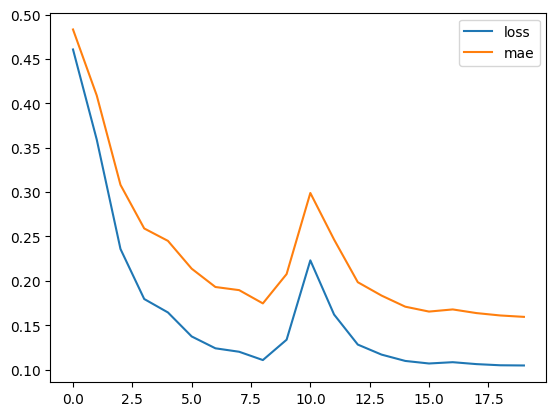

In [23]:
pd.DataFrame( history.history).plot()
plt.show()

In [24]:
def preprocess( img) :
    
    img= img/255
    img = cv2.resize(img ,(299,299) )
    img = img.reshape((1, img.shape[0] , img.shape[1] , img.shape[2] ))
    return img 


In [25]:

# coord = Lstm_net.predict( Img_data[:1])
# x = coord[0][0]
# y = coord[0][1]

Cor = []

index = 1
img1 = Original_img[index]
# img1 = img 

for i in  range( 10 ) :
    img = img1
    img = preprocess(img)
    coord = Lstm_net.predict( img )
    x = coord[0][0]
    y = coord[0][1]
    x1 = x + 40 
    y1 = y + 40
    
    t = ( int(x) , int(y))
    t1 = ( int(x1) , int(y1))
    
    Cor.append([t , t1])
    cv2.rectangle( img1 , t , t1 , (0 ,255, 0)  , 3 )
    
    
    

    
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


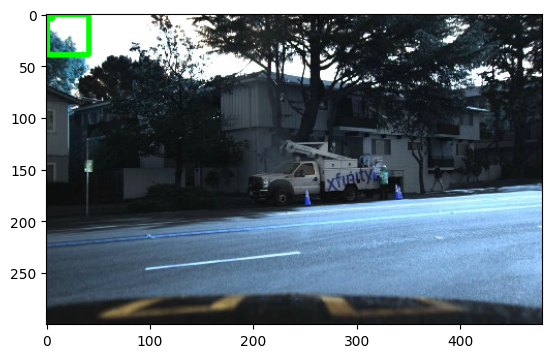

[[(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)],
 [(1, 0), (41, 39)]]

In [26]:

plt.imshow( Original_img[ 1] , cmap = 'gray')
plt.show()

Cor